# NBA Data :: Principal Component Analysis

Trevor Rowland - 2/27/25

This notebook aims to create a Principal Component Analysis (PCA) to identify important features and reduce the size of the dataset.

The dataset we will be using is the `games_merged_endpoints.csv` file, which can be accessed with the following code block. Going forwards, this dataset and the reduced dataset from the PCA will be used. The README file will be updated to reflect this change.

**THINGS THAT I NEED TO EDIT**

- Remove features! Follow lecture 9 stuff!
- The correct number of Principal Components needs to be chosen
- The notebook needs to be edited and rerun with the new number of PCs

The tutorial I followed to create this PCA can be found [here](<https://builtin.com/machine-learning/pca-in-python>).

In [80]:
import pandas as pd

gdrive_url = 'https://drive.google.com/file/d/1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF/view?usp=drive_link'

file_id = '1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url, encoding='utf-8')

In [81]:
df = df[df['season'].str[:4].astype(int) > 2013]

In [82]:
print(df.columns.tolist())

['game_id', 'season', 'team_id', 'team_name', 'tri_code', 'team_slug', 'minutes', 'field_goals_made', 'field_goals_attempted', 'field_goals_percentage', 'three_pointers_made', 'three_pointers_attempted', 'three_pointers_percentage', 'free_throws_made', 'free_throws_attempted', 'free_throws_percentage', 'rebounds_offensive', 'rebounds_defensive', 'rebounds_total', 'steals', 'blocks', 'turnovers', 'fouls_personal', 'points', 'plus_minus_points', 'estimated_offensive_rating', 'offensive_rating', 'estimated_defensive_rating', 'defensive_rating', 'estimated_net_rating', 'net_rating', 'assist_percentage', 'assist_to_turnover', 'assist_ratio', 'offensive_rebound_percentage', 'defensive_rebound_percentage', 'rebound_percentage', 'estimated_team_turnover_percentage', 'turnover_ratio', 'effective_field_goal_percentage', 'true_shooting_percentage', 'usage_percentage', 'estimated_usage_percentage', 'estimated_pace', 'pace', 'pace_per40', 'possessions', 'p_i_e', 'distance', 'rebound_chances_offensi

In [83]:
df.head()

,game_id,season,team_id,team_name,tri_code,team_slug,minutes,field_goals_made,field_goals_attempted,field_goals_percentage,...,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game,is_playoff_game,is_regular_game
13932,41400406,2014-15,1610612739,Cavaliers,CLE,cavaliers,240:00,32.0,82.0,0.390,...,0.316,0.390,17.0,28.0,0.607,105.0,1,0,1,0
13933,41400405,2014-15,1610612744,Warriors,GSW,warriors,240:00,36.0,75.0,0.480,...,0.548,0.480,11.0,22.0,0.500,91.0,1,1,1,0
13934,41400404,2014-15,1610612739,Cavaliers,CLE,cavaliers,240:00,29.0,88.0,0.330,...,0.238,0.330,9.0,14.0,0.643,103.0,1,0,1,0
13935,41400403,2014-15,1610612739,Cavaliers,CLE,cavaliers,240:00,35.0,76.0,0.461,...,0.467,0.461,12.0,24.0,0.500,91.0,1,1,1,0
13936,41400402,2014-15,1610612744,Warriors,GSW,warriors,265:00,33.0,83.0,0.398,...,0.404,0.398,7.0,19.0,0.368,95.0,1,0,1,0


## 0. Identifying a Target Variable

Before performing any PCA tasks, we must first identify a **target variable**. The PCA tool requires a split between response and predictor variables, so a target must be chosen. This will be done by assessing the correlations between variables, and a variable with the highest correlation across predictor variables is a good place to start for a target.

<Axes: >

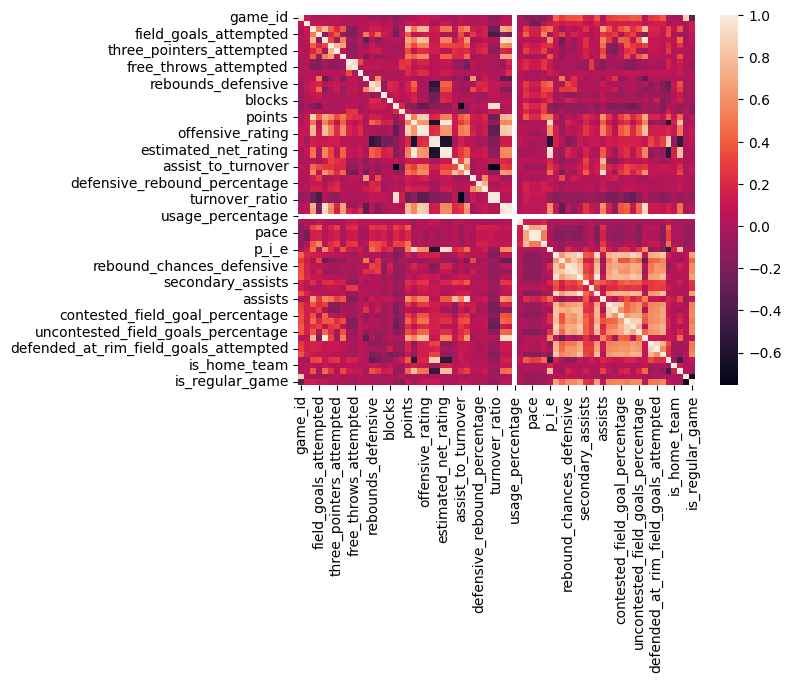

In [84]:
import seaborn as sns
%matplotlib inline

# load the Auto dataset

# calculate the correlation matrix on the numeric columns
corr = df.select_dtypes('number').corr()

# plot the heatmap
sns.heatmap(corr)

This chart is fairly inconclusive. After a meeting, we were told to first investigate points per game (PPG), or `points` in our dataset.

In [85]:
corr['points'].sort_values(ascending=False)

points                                1.000000
offensive_rating                      0.869015
field_goals_made                      0.864466
estimated_offensive_rating            0.857955
true_shooting_percentage              0.782469
                                        ...   
rebound_chances_offensive            -0.094210
turnovers                            -0.115583
turnover_ratio                       -0.237949
estimated_team_turnover_percentage   -0.242462
usage_percentage                           NaN
Name: points, Length: 67, dtype: float64

In [86]:
corr['opponent_points'].sort_values(ascending=False)

opponent_points               1.000000
estimated_defensive_rating    0.857236
defensive_rating              0.855382
possessions                   0.470780
points                        0.404093
                                ...   
p_i_e                        -0.502319
estimated_net_rating         -0.529883
net_rating                   -0.538949
plus_minus_points            -0.540402
usage_percentage                   NaN
Name: opponent_points, Length: 67, dtype: float64

From this we have 2 options. We can either investigate home team points (`points`) further, or we can examine what is making away teams win more `opponent_points`. Let's focus on team points for now, and examine away teams only if necessary.

This makes our target variable `points`, and the predictor variables are the rest of the numeric variables in the dataset.

## 1. Scale the Data

To perform the PCA, data must first be scaled to standardize it to have a mean of 0, and a standard deviation of 1. This will be done with `sklearn`'s `StandardScaler` tool. Additionally, ID values like `game_id`, `team_id`, etc. will be filtered out.

In [87]:
df_numeric = df.select_dtypes('number')
df_numeric.head()

pca_df = df_numeric.drop(['game_id','team_id','is_home_team','won_game','is_playoff_game','is_regular_game'], axis=1)

pca_df = pca_df.dropna()

pca_df.head()

,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,free_throws_made,free_throws_attempted,free_throws_percentage,rebounds_offensive,...,contested_field_goals_attempted,contested_field_goal_percentage,uncontested_field_goals_made,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points
13932,32.0,82.0,0.390,6.0,26.0,0.231,27.0,39.0,0.692,16.0,...,44.0,0.455,12.0,38.0,0.316,0.390,17.0,28.0,0.607,105.0
13933,36.0,75.0,0.480,12.0,26.0,0.462,20.0,34.0,0.588,11.0,...,33.0,0.394,23.0,42.0,0.548,0.480,11.0,22.0,0.500,91.0
13934,29.0,88.0,0.330,4.0,27.0,0.148,20.0,28.0,0.714,16.0,...,46.0,0.413,10.0,42.0,0.238,0.330,9.0,14.0,0.643,103.0
13935,35.0,76.0,0.461,9.0,21.0,0.429,17.0,24.0,0.708,6.0,...,46.0,0.457,14.0,30.0,0.467,0.461,12.0,24.0,0.500,91.0
13936,33.0,83.0,0.398,8.0,35.0,0.229,19.0,25.0,0.760,10.0,...,36.0,0.389,19.0,47.0,0.404,0.398,7.0,19.0,0.368,95.0


In [88]:
print(pca_df.columns.tolist())

['field_goals_made', 'field_goals_attempted', 'field_goals_percentage', 'three_pointers_made', 'three_pointers_attempted', 'three_pointers_percentage', 'free_throws_made', 'free_throws_attempted', 'free_throws_percentage', 'rebounds_offensive', 'rebounds_defensive', 'rebounds_total', 'steals', 'blocks', 'turnovers', 'fouls_personal', 'points', 'plus_minus_points', 'estimated_offensive_rating', 'offensive_rating', 'estimated_defensive_rating', 'defensive_rating', 'estimated_net_rating', 'net_rating', 'assist_percentage', 'assist_to_turnover', 'assist_ratio', 'offensive_rebound_percentage', 'defensive_rebound_percentage', 'rebound_percentage', 'estimated_team_turnover_percentage', 'turnover_ratio', 'effective_field_goal_percentage', 'true_shooting_percentage', 'usage_percentage', 'estimated_usage_percentage', 'estimated_pace', 'pace', 'pace_per40', 'possessions', 'p_i_e', 'distance', 'rebound_chances_offensive', 'rebound_chances_defensive', 'rebound_chances_total', 'touches', 'secondary_

Now we can begin the PCA process. Let's scale the data with `StandardScaler`.

In [89]:
from sklearn.preprocessing import StandardScaler

response = ['points']
predictors = ['field_goals_made', 
    'field_goals_attempted', 
    'field_goals_percentage', 
    'three_pointers_made', 
    'three_pointers_attempted', 
    'three_pointers_percentage', 
    'free_throws_made', 
    'free_throws_attempted', 
    'free_throws_percentage', 
    'rebounds_offensive', 
    'rebounds_defensive', 
    'rebounds_total', 
    'steals', 
    'blocks', 
    'turnovers', 
    'fouls_personal',
    'plus_minus_points', 
    'estimated_offensive_rating', 
    'offensive_rating', 
    'estimated_defensive_rating', 
    'defensive_rating', 
    'estimated_net_rating', 
    'net_rating', 
    'assist_percentage', 
    'assist_to_turnover', 
    'assist_ratio', 
    'offensive_rebound_percentage', 
    'defensive_rebound_percentage', 
    'rebound_percentage', 
    'estimated_team_turnover_percentage',
    'turnover_ratio', 
    'effective_field_goal_percentage', 
    'true_shooting_percentage', 
    'usage_percentage', 
    'estimated_usage_percentage', 
    'estimated_pace', 
    'pace', 
    'pace_per40', 
    'possessions', 
    'p_i_e', 
    'distance', 
    'rebound_chances_offensive', 
    'rebound_chances_defensive', 
    'rebound_chances_total', 
    'touches', 
    'secondary_assists', 
    'free_throw_assists', 
    'passes', 
    'assists', 
    'contested_field_goals_made', 
    'contested_field_goals_attempted', 
    'contested_field_goal_percentage', 
    'uncontested_field_goals_made', 
    'uncontested_field_goals_attempted', 
    'uncontested_field_goals_percentage', 
    'field_goal_percentage', 
    'defended_at_rim_field_goals_made', 
    'defended_at_rim_field_goals_attempted', 
    'defended_at_rim_field_goal_percentage', 
    'opponent_points'
]

# Split the DF

x = pca_df.loc[:, predictors].values
y = pca_df.loc[:,response].values

x = StandardScaler().fit_transform(x)


In [90]:
pca_df.columns.value_counts().sum()

61

Now that the features have been scaled, we can begin the dimensionality reduction.

# 2. PCA Projection to 2D

The dataframe `pca_df` currently has 61 total columns, or **60 predictor variables**. I am assuming that we need to reduce this into 2 dimensions like in the tutorial.

In [91]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1','pc2', 'pc3'])

In [92]:
finalDf = pd.concat([principalDf, df[['points']]], axis=1)
finalDf.head()

,pc1,pc2,pc3,points
0,-3.227712,4.174492,-3.028318,NaN
1,1.537009,-0.198349,-3.405830,NaN
2,-4.473255,6.357223,-0.973117,NaN
3,-1.443797,0.637471,-3.327035,NaN
4,-3.399564,1.959533,-3.771117,NaN


## 3. Visualizing the 2D Projection

Now we can plot the dimensionally-reduced data.

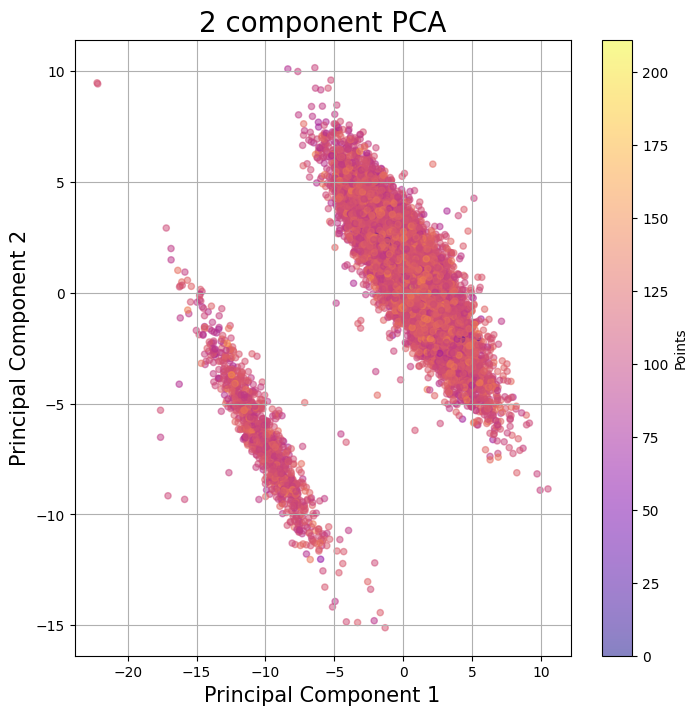

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
scatter = plt.scatter(finalDf['pc1'], finalDf['pc2'],
                      c=finalDf['points'], cmap='plasma', 
                      s=20, alpha=0.5)
plt.colorbar(scatter, label="Points")
plt.xlabel('Principal Component 1', fontsize=15)
plt.ylabel('Principal Component 2', fontsize=15)
plt.title('2 component PCA', fontsize=20)
plt.grid()
plt.show()


Now we can see the Explained Variance of the PCA, and begin to interpret the results.

In [ ]:
pca.explained_variance_ratio_

array([0.21734809, 0.160815  ])

In [ ]:
pca.explained_variance_

array([12.82400517,  9.48843104])

In [ ]:
# Assuming 'pca' is your PCA model and 'predictors' contains the feature names
loadings = pd.DataFrame(pca.components_, columns=predictors, index=['PC1', 'PC2'])

# View the top contributing features to PC1 and PC2
print(loadings.T.sort_values(by='PC1', ascending=False).head(10))  # Top PC1 contributors


                                         PC1       PC2
uncontested_field_goals_made        0.239909  0.054891
uncontested_field_goals_percentage  0.238707  0.079888
contested_field_goal_percentage     0.221065  0.094824
distance                            0.210752  0.195080
uncontested_field_goals_attempted   0.207281  0.152613
touches                             0.202519  0.195394
offensive_rating                    0.197196 -0.171278
passes                              0.196897  0.187573
estimated_offensive_rating          0.195768 -0.181025
contested_field_goals_made          0.189430  0.127597


In [ ]:
print(loadings.T.sort_values(by='PC2', ascending=False).head(10))  # Top PC2 contributors

                                            PC1       PC2
rebound_chances_offensive              0.099251  0.215501
contested_field_goals_attempted        0.156441  0.204682
touches                                0.202519  0.195394
rebound_chances_total                  0.166358  0.195174
distance                               0.210752  0.195080
defended_at_rim_field_goal_percentage  0.176321  0.188958
passes                                 0.196897  0.187573
defended_at_rim_field_goals_made       0.163027  0.156784
uncontested_field_goals_attempted      0.207281  0.152613
rebound_chances_defensive              0.181546  0.151392
